# MCMC for 2D hard spheres

## Q1

We randomly choose the disk positions using the naive algorithm: putting the disks in one by one and checking for overlaps at each step.

An example of the position for disk radius 0.3


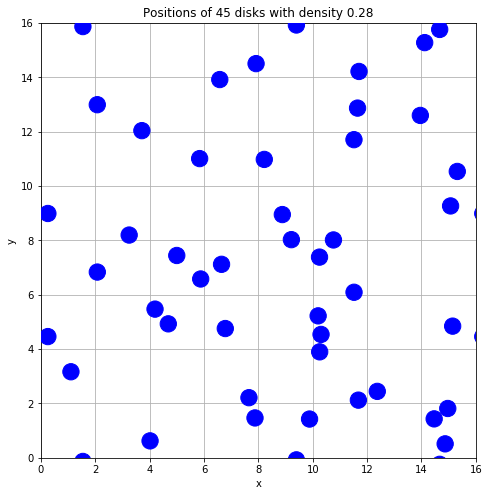

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def graph(positions, density):
    sig = np.sqrt(density / np.pi)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    plt.grid()
    
    for coords in positions:
        if coords[0] < sig:
            circle = plt.Circle((coords[0] + L, coords[1]), sig, color='b',zorder=5)
            ax.add_artist(circle)
            #circle = plt.Circle((coords[0] + L, coords[1]), sig, fill=False, color='k', zorder=6)
            #ax.add_artist(circle)
        elif coords[0] > L - sig:
            circle = plt.Circle((coords[0] - L, coords[1]), sig, color='b',zorder=5)
            ax.add_artist(circle)
            #circle = plt.Circle((coords[0] - L, coords[1]), sig, fill=False, color='k', zorder=6)
            #ax.add_artist(circle)
        if coords[1] < sig:
            circle = plt.Circle((coords[0], coords[1] + L), sig, color='b',zorder=5)
            ax.add_artist(circle)
            #circle = plt.Circle((coords[0], coords[1] + L), sig, fill=False, color='k', zorder=6)
            #ax.add_artist(circle)
        elif coords[1] > L - sig:
            circle = plt.Circle((coords[0], coords[1] - L), sig, color='b',zorder=5)
            ax.add_artist(circle)
            #circle = plt.Circle((coords[0], coords[1] - L), sig, fill=False, color='k', zorder=6)
            #ax.add_artist(circle)   
        circle = plt.Circle((coords[0], coords[1]), sig, color='b',zorder=5)
        ax.add_artist(circle)
    plt.axes().set_aspect('equal')
    plt.title(f"Positions of {n} disks with density {density:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim([0,16])
    plt.ylim([0,16])
    plt.show()
    plt.close("all")

L = 16
n = 45
sig = 0.3
density = np.pi * sig**2
runs = 1
success = 0

while success < runs:
    good = False
    while not good:
        positions = np.random.uniform(0, L, (n,2))
        good = True
        for i in range(n):
            for j in range(i):
                if (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2 < (2*sig)**2:
                    good = False
                    break
        success += 1
print(f"An example of the position for disk radius {sig}")
graph(positions, density)

Next we explore the time needed for this naive algorithm to find an allowed configuration, as a function of the number of disks.

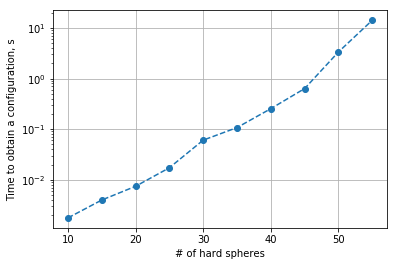

In [31]:
nn = [10 + 5*i for i in range(10)]
sig = 0.3
runs = 5
all_times = []

for n in nn:
    times = []
    for run in range(runs):
        all_positions = np.zeros((runs, n, 2))
        start = time.time()
        success = 0
        while success < runs:

            good = False
            while not good:
                positions = np.random.uniform(0, L, (n,2))
                good = True
                for i in range(n):
                    for j in range(i):
                        if (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2 < (2*sig)**2:
                            good = False
                            break
            all_positions[success] = positions
            success += 1 
        times.append(time.time() - start)
    all_times.append(np.mean(times))

fig = plt.figure()
plt.title("")
plt.xlabel("# of hard spheres")
plt.ylabel("Time to obtain a configuration, s")
plt.semilogy(nn, all_times, 'o', linestyle='--')
plt.grid()
plt.show()
plt.close("all")

### Q2

In order to apply MCMC to disks, we will initialize them as a square lattice.

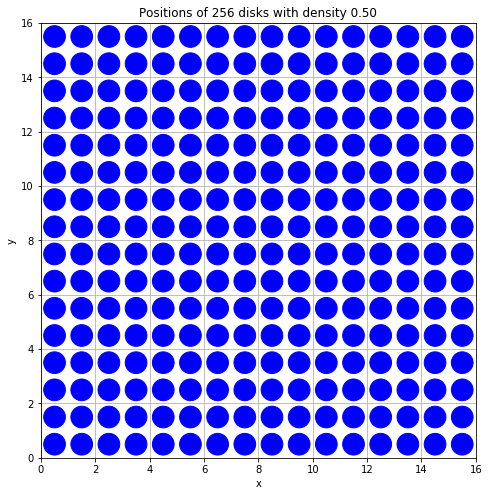

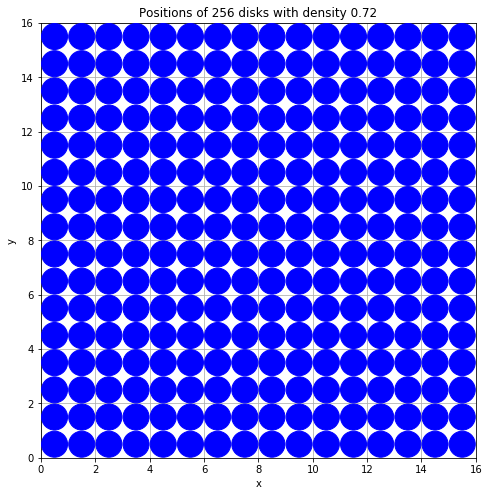

In [2]:
densities = [0.5, 0.72]
grid = np.arange(0,L) + 0.5
positions = np.array([])

for i in range(L**2):
    initial_position = [grid[i % L], grid[i // L]]
    positions = np.append(positions, initial_position)
n = len(positions) // 2
positions = np.reshape(positions, (n,2))

for density in densities:
    graph(positions, density)

initial = np.copy(positions)

### Q3 + Q4 / Bonus

We will now explore the evolution of the disks with the MCMC algorithm. Stepsize for each density was determined "manually" using the 1/2-rule of accepted steps.

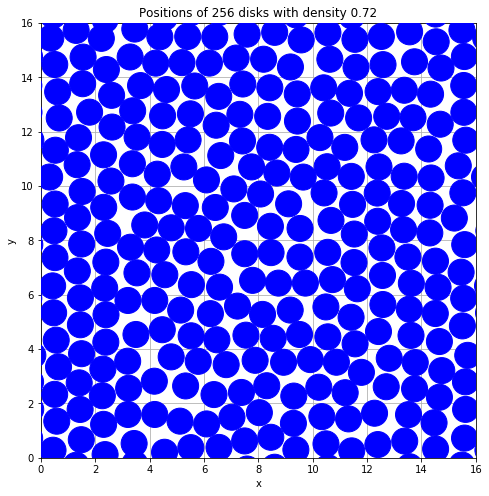

Acceptance ratio:
0.48766


In [18]:
starttime = time.time()
L = 16
density = 0.72
sig = np.sqrt(density / np.pi)
stepsize = sig * 0.1
runs = 2*10**5
accepted = 0
grid = np.arange(0,L) + 0.5
positions = np.array([])

for i in range(L**2):
    initial_position = [grid[i % L], grid[i // L]]
    positions = np.append(positions, initial_position)      
n = len(positions) // 2
positions = np.reshape(positions, (n,2))

for run in range(runs):
    kill_run = False
    to_move = np.random.randint(0,n)
    
    #to_move = 1

    dx, dy = np.random.uniform(-stepsize, stepsize), np.random.uniform(-stepsize, stepsize)
    new_pos = positions[to_move] + [dx, dy]

    #new_pos = positions[to_move] + [0, -0.15]
    
    new_pos2 = np.copy(new_pos) # will need to check for overlap before teleporting to other side as well
    clonex = np.copy(new_pos) # same for x axis for being 0<distance<sig far from the boundary
    cloney = np.copy(new_pos) # same for y axis for being 0<distance<sig far from the boundary
    
    teleported = False
    clonedx = False
    clonedy = False
    
    if new_pos[0] < sig:
        clonex[0] += L
        if new_pos[0] < 0:
            new_pos[0] = L - new_pos[0]
    elif new_pos[0] > L - sig:
        clonex[0] -= L
        if new_pos[0] > L:
            new_pos[0] = new_pos[0] - L
    if np.sum(new_pos) != np.sum(clonex):
        clonedx = True
    if clonedx: # checks overlaps for x clone over periodic boundary
        for i in range(n):
            if (positions[i,0] - clonex[0])**2 + (positions[i,1] - clonex[1])**2 < (2*sig)**2:
                if i == to_move:
                    continue
                kill_run = True
                break   
    if kill_run:
        #print(661)
        continue
        
    if new_pos[1] < sig:
        cloney[1] += L
        if new_pos[1] < 0:
            new_pos[1] = L - new_pos[1]
    elif new_pos[1] > L - sig:
        cloney[1] -= L
        if new_pos[1] > L:
            new_pos[1] = new_pos[1] - L
    if np.sum(new_pos) != np.sum(cloney):
        clonedy = True
    if clonedy: # checks overlaps for y clone over periodic boundary
        for i in range(n):
            if (positions[i,0] - cloney[0])**2 + (positions[i,1] - cloney[1])**2 < (2*sig)**2:
                if i == to_move:
                    continue
                kill_run = True
                break 
    if kill_run:
        #print(662)
        continue  
        
    for i in range(n):
        if (positions[i,0] - new_pos[0])**2 + (positions[i,1] - new_pos[1])**2 < (2*sig)**2:
            if i == to_move:
                continue
            kill_run = True
            break
    if kill_run:
        #print(55)
        continue 
        
    if np.sum(new_pos) != np.sum(new_pos2):
        teleported = True      
    if teleported: # checks overlaps for location before teleport
        for i in range(n):
            if (positions[i,0] - new_pos2[0])**2 + (positions[i,1] - new_pos2[1])**2 < (2*sig)**2:
                if i == to_move:
                    continue
                kill_run = True
                break
    if kill_run:
        #print(77)
        continue
        
    accepted += 1
    positions[to_move] = new_pos   
    
graph(positions,density)
    
newest_positions = np.copy(positions)

print("Acceptance ratio:")  
print(accepted / runs)

#print("Time taken:")
#print(time.time() - starttime)

The above plot depicts the system after 200k MCMC steps. Some regions of hexagonal lattice can be distinguished, for example near the left and right borders of the plot. One might considired that a different phase.

 ### Order parameter

We will introduce an order parameter for the $i$-th disk:
$$
\begin{equation}
\psi_6(i) = \frac{1}{\# \ of neighbours} \sum_{neighbours}{e^{6 i \phi_{ij}}}
\end{equation}
$$
where $\phi_{ij}$ is defined as the angle between the line joining the centers of the neighbouring disks and the $x$ axis.
Neighbouring disks are those that are closer than $2.8\sigma$ to the given disk.

In the initial square lattice this order parameter evaluates to 0 for every disk. 

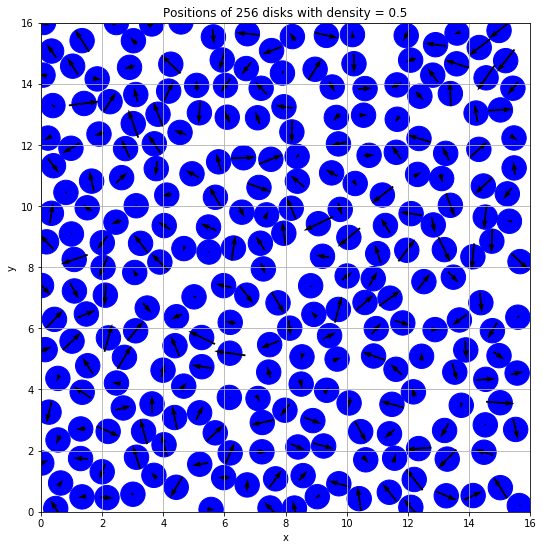

Average magnitude of the order parameter:
0.438429008644


In [8]:
tolerance = 2.8 * sig
all_phis = np.array([])

for j in range(n):
    neigh = 0
    phi = []

    clonex = np.copy(positions[j])
    cloney = np.copy(positions[j])
    clonedx = False
    clonedy = False

    if positions[j,0] < tolerance:
        clonex[0] += L
    elif positions[j,0] > L - tolerance:
        clonex[0] -= L
    if np.sum(positions[j]) != np.sum(clonex):
        clonedx = True

    if positions[j,1] < tolerance:
        cloney[1] += L
    elif positions[j,1] > L - tolerance:
        cloney[1] -= L
    if np.sum(positions[j]) != np.sum(cloney):
        clonedy = True

    for i in range(n):
        if clonedx:
            if (positions[i,0] - clonex[0])**2 + (positions[i,1] - clonex[1])**2 < (tolerance)**2:
                if i == to_move:
                    continue
                neigh += 1
                angle = 6 * np.arctan2(positions[i,1] - clonex[1], positions[i,0] - clonex[0])
                magnitude2 = (positions[i,0] - clonex[0])**2 + (positions[i,1] - clonex[1])**2
                magnitude = np.sqrt(magnitude2)
                phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])

        if clonedy:
            if (positions[i,0] - cloney[0])**2 + (positions[i,1] - cloney[1])**2 < (tolerance)**2:
                neigh += 1
                angle = 6 * np.arctan2(positions[i,1] - cloney[1], positions[i,0] - cloney[0])
                magnitude2 = (positions[i,0] - cloney[0])**2 + (positions[i,1] - cloney[1])**2
                magnitude = np.sqrt(magnitude2)
                phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])

        if (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2 < (tolerance)**2:
            #if i == j:
             #   continue
            neigh += 1
            angle = 6 * np.arctan2(positions[i,1] - positions[j,1], positions[i,0] - positions[j,0])
            magnitude2 = (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2
            magnitude = np.sqrt(magnitude2)
            phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])
    phi = np.sum(phi,0)
    phi /= neigh
    all_phis = np.append(all_phis, phi)


all_phis = np.reshape(all_phis, (n, 2))
all_phis = np.round(all_phis, decimals = 6)

fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
plt.grid()
for i in range(len(positions)):
    circle = plt.Circle((positions[i,0], positions[i,1]), np.sqrt(density / np.pi), color='b',zorder=0)
    ax.add_artist(circle)
Q = plt.quiver(positions[:,0], positions[:,1], all_phis[:,0], all_phis[:,1],
               pivot='mid', units='inches')
plt.axes().set_aspect('equal')
plt.title(r"Positions of " + str(n) + " disks with density = " + str(density))
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,16])
plt.ylim([0,16])
plt.show()
plt.close("all")
print("Average magnitude of the order parameter:")
print(np.sqrt(np.mean(all_phis[:,0]**2 + np.mean(all_phis[:,1]**2))))



For $\rho = 0.5$ the order parameter does not seem to express any structure, as can be observed in the plot above.



Next we plot the same order parameter for the $\rho = 0.72$ case.

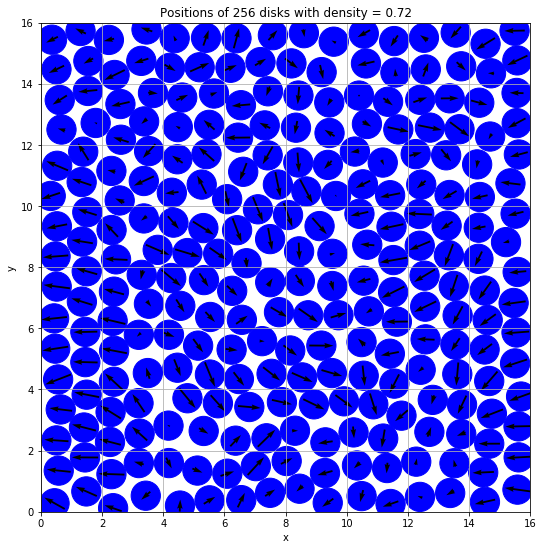

Average magnitude of the order parameter:
0.588769504736


In [19]:
tolerance = 2.8 * sig
all_phis = np.array([])

for j in range(n):
    neigh = 0
    phi = []

    clonex = np.copy(positions[j])
    cloney = np.copy(positions[j])
    clonedx = False
    clonedy = False

    if positions[j,0] < tolerance:
        clonex[0] += L
    elif positions[j,0] > L - tolerance:
        clonex[0] -= L
    if np.sum(positions[j]) != np.sum(clonex):
        clonedx = True

    if positions[j,1] < tolerance:
        cloney[1] += L
    elif positions[j,1] > L - tolerance:
        cloney[1] -= L
    if np.sum(positions[j]) != np.sum(cloney):
        clonedy = True

    for i in range(n):
        if clonedx:
            if (positions[i,0] - clonex[0])**2 + (positions[i,1] - clonex[1])**2 < (tolerance)**2:
                if i == to_move:
                    continue
                neigh += 1
                angle = 6 * np.arctan2(positions[i,1] - clonex[1], positions[i,0] - clonex[0])
                magnitude2 = (positions[i,0] - clonex[0])**2 + (positions[i,1] - clonex[1])**2
                magnitude = np.sqrt(magnitude2)
                phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])

        if clonedy:
            if (positions[i,0] - cloney[0])**2 + (positions[i,1] - cloney[1])**2 < (tolerance)**2:
                neigh += 1
                angle = 6 * np.arctan2(positions[i,1] - cloney[1], positions[i,0] - cloney[0])
                magnitude2 = (positions[i,0] - cloney[0])**2 + (positions[i,1] - cloney[1])**2
                magnitude = np.sqrt(magnitude2)
                phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])

        if (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2 < (tolerance)**2:
            #if i == j:
             #   continue
            neigh += 1
            angle = 6 * np.arctan2(positions[i,1] - positions[j,1], positions[i,0] - positions[j,0])
            magnitude2 = (positions[i,0] - positions[j,0])**2 + (positions[i,1] - positions[j,1])**2
            magnitude = np.sqrt(magnitude2)
            phi.append([magnitude * np.cos(angle), magnitude * np.sin(angle)])
    phi = np.sum(phi,0)
    phi /= neigh
    all_phis = np.append(all_phis, phi)


all_phis = np.reshape(all_phis, (n, 2))
all_phis = np.round(all_phis, decimals = 6)

fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
plt.grid()
for i in range(len(positions)):
    circle = plt.Circle((positions[i,0], positions[i,1]), np.sqrt(density / np.pi), color='b',zorder=0)
    ax.add_artist(circle)
Q = plt.quiver(positions[:,0], positions[:,1], all_phis[:,0], all_phis[:,1],
               pivot='mid', units='inches')
plt.axes().set_aspect('equal')
plt.title(r"Positions of " + str(n) + " disks with density = " + str(density))
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,16])
plt.ylim([0,16])
plt.show()
plt.close("all")
print("Average magnitude of the order parameter:")
print(np.sqrt(np.mean(all_phis[:,0]**2 + np.mean(all_phis[:,1]**2))))



Here we can observe that hexagonal lattice-like regions have formed, as indicated by neighbouring disks with their order parameters aligned. That may be characterized as a liquid-solid phase transition. Though that can not be easily seen just from the average magnitude of the order parameter alone, as it is not distinctively larger than the $\rho = 0.5$ case.

Calculating the average magnitude of $\psi_6$ may not always give means to determine a phase transition, as there may be multiple "solid/hexagonal" phases with their order parameter pointing in opposite directions, so that the final average magnitude is rather small.

Use of order parameter plots is therefore advised to identify possible hexagonal phases.